In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 

# Feature Selection

To this point we've looked at a few things that we can do to "tune" our models, or make them more accurate, such as:
<ul>
<li> Grid search to test different hyperparameters. 
<li> Regularization. 
<li> Bagging ensembles with bootstrapping. 
<li> Basis functions to allow more degrees of freedom for our models to fit data. 
<li> Pruning tree based models. 
<li> Early stopping - stopping training when accuracy is best. (We'll look at this more later)
</ul>

These tuning techinques all focused on what happens to the model, or what the model is allowed to do, as it is training. We can add to this by focusing on improving models by carefully choosing which pieces of data to use in the feature set, or feature selection. 

### Load Some Data

We can look at some feature selection techniques to try to determine which of these features is important and which are more noise. 

#### Classification Data

This data is on cell phones, the target is the varaible "price_range" - a multi-way classification. 

In [2]:
df = pd.read_csv("data/phone_train.csv")
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [3]:
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
battery_power,2000.0,1238.51850,439.418206,501.0,851.75,1226.0,1615.25,1998.0
blue,2000.0,0.49500,0.500100,0.0,0.00,0.0,1.00,1.0
clock_speed,2000.0,1.52225,0.816004,0.5,0.70,1.5,2.20,3.0
dual_sim,2000.0,0.50950,0.500035,0.0,0.00,1.0,1.00,1.0
fc,2000.0,4.30950,4.341444,0.0,1.00,3.0,7.00,19.0
four_g,2000.0,0.52150,0.499662,0.0,0.00,1.0,1.00,1.0
int_memory,2000.0,32.04650,18.145715,2.0,16.00,32.0,48.00,64.0
m_dep,2000.0,0.50175,0.288416,0.1,0.20,0.5,0.80,1.0
mobile_wt,2000.0,140.24900,35.399655,80.0,109.00,141.0,170.00,200.0
n_cores,2000.0,4.52050,2.287837,1.0,3.00,4.0,7.00,8.0


In [4]:
y = df["price_range"]
X = df.drop(columns={"price_range"})

#### Regression Data

This data is on cars, the target is the variable "mpg" - a regression problem.

In [5]:
#Load some regression data
df_reg = pd.read_csv("data/mtcars.csv")
df_reg.drop(columns={"model"}, inplace=True)
df_reg.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [6]:
yreg = df_reg["mpg"]
Xreg = df_reg.drop(columns={"mpg"})

## Insepection

The first and most important method of feature selection is something that we started looking at in Stats, examining the data to see if there are any obvious problems. 

We can look for things like:
<ul>
<li> Features that don't vary much - if a value is always the same, that isn't helpful in making predictions. 
<li> Features that are not useful from a domain knowledge persepective - if we understand the problem we are attempting to solve, we can sometimes see that a feature is not useful.
<li> Features that are highly correlated with other features or  multicolinierity - if two features are highly correlated, we can often drop one of them. 
</ul>

This manual first pass may be substantial, especially if we are dealing with data "from the wild" that is likely to be messy. For data that is more structured, it is less likely that we will need to do much here. For data that is largely numerical, the pairplot is likely a good way to get a quick overall look at the data, and idetnify any places where we may want to look more closely. For categorical data, we can look at the counts of each category, and the distribution of the target variable for each category with something like a countplot. The tool choice here is largely a matter of taste and the data at hand.

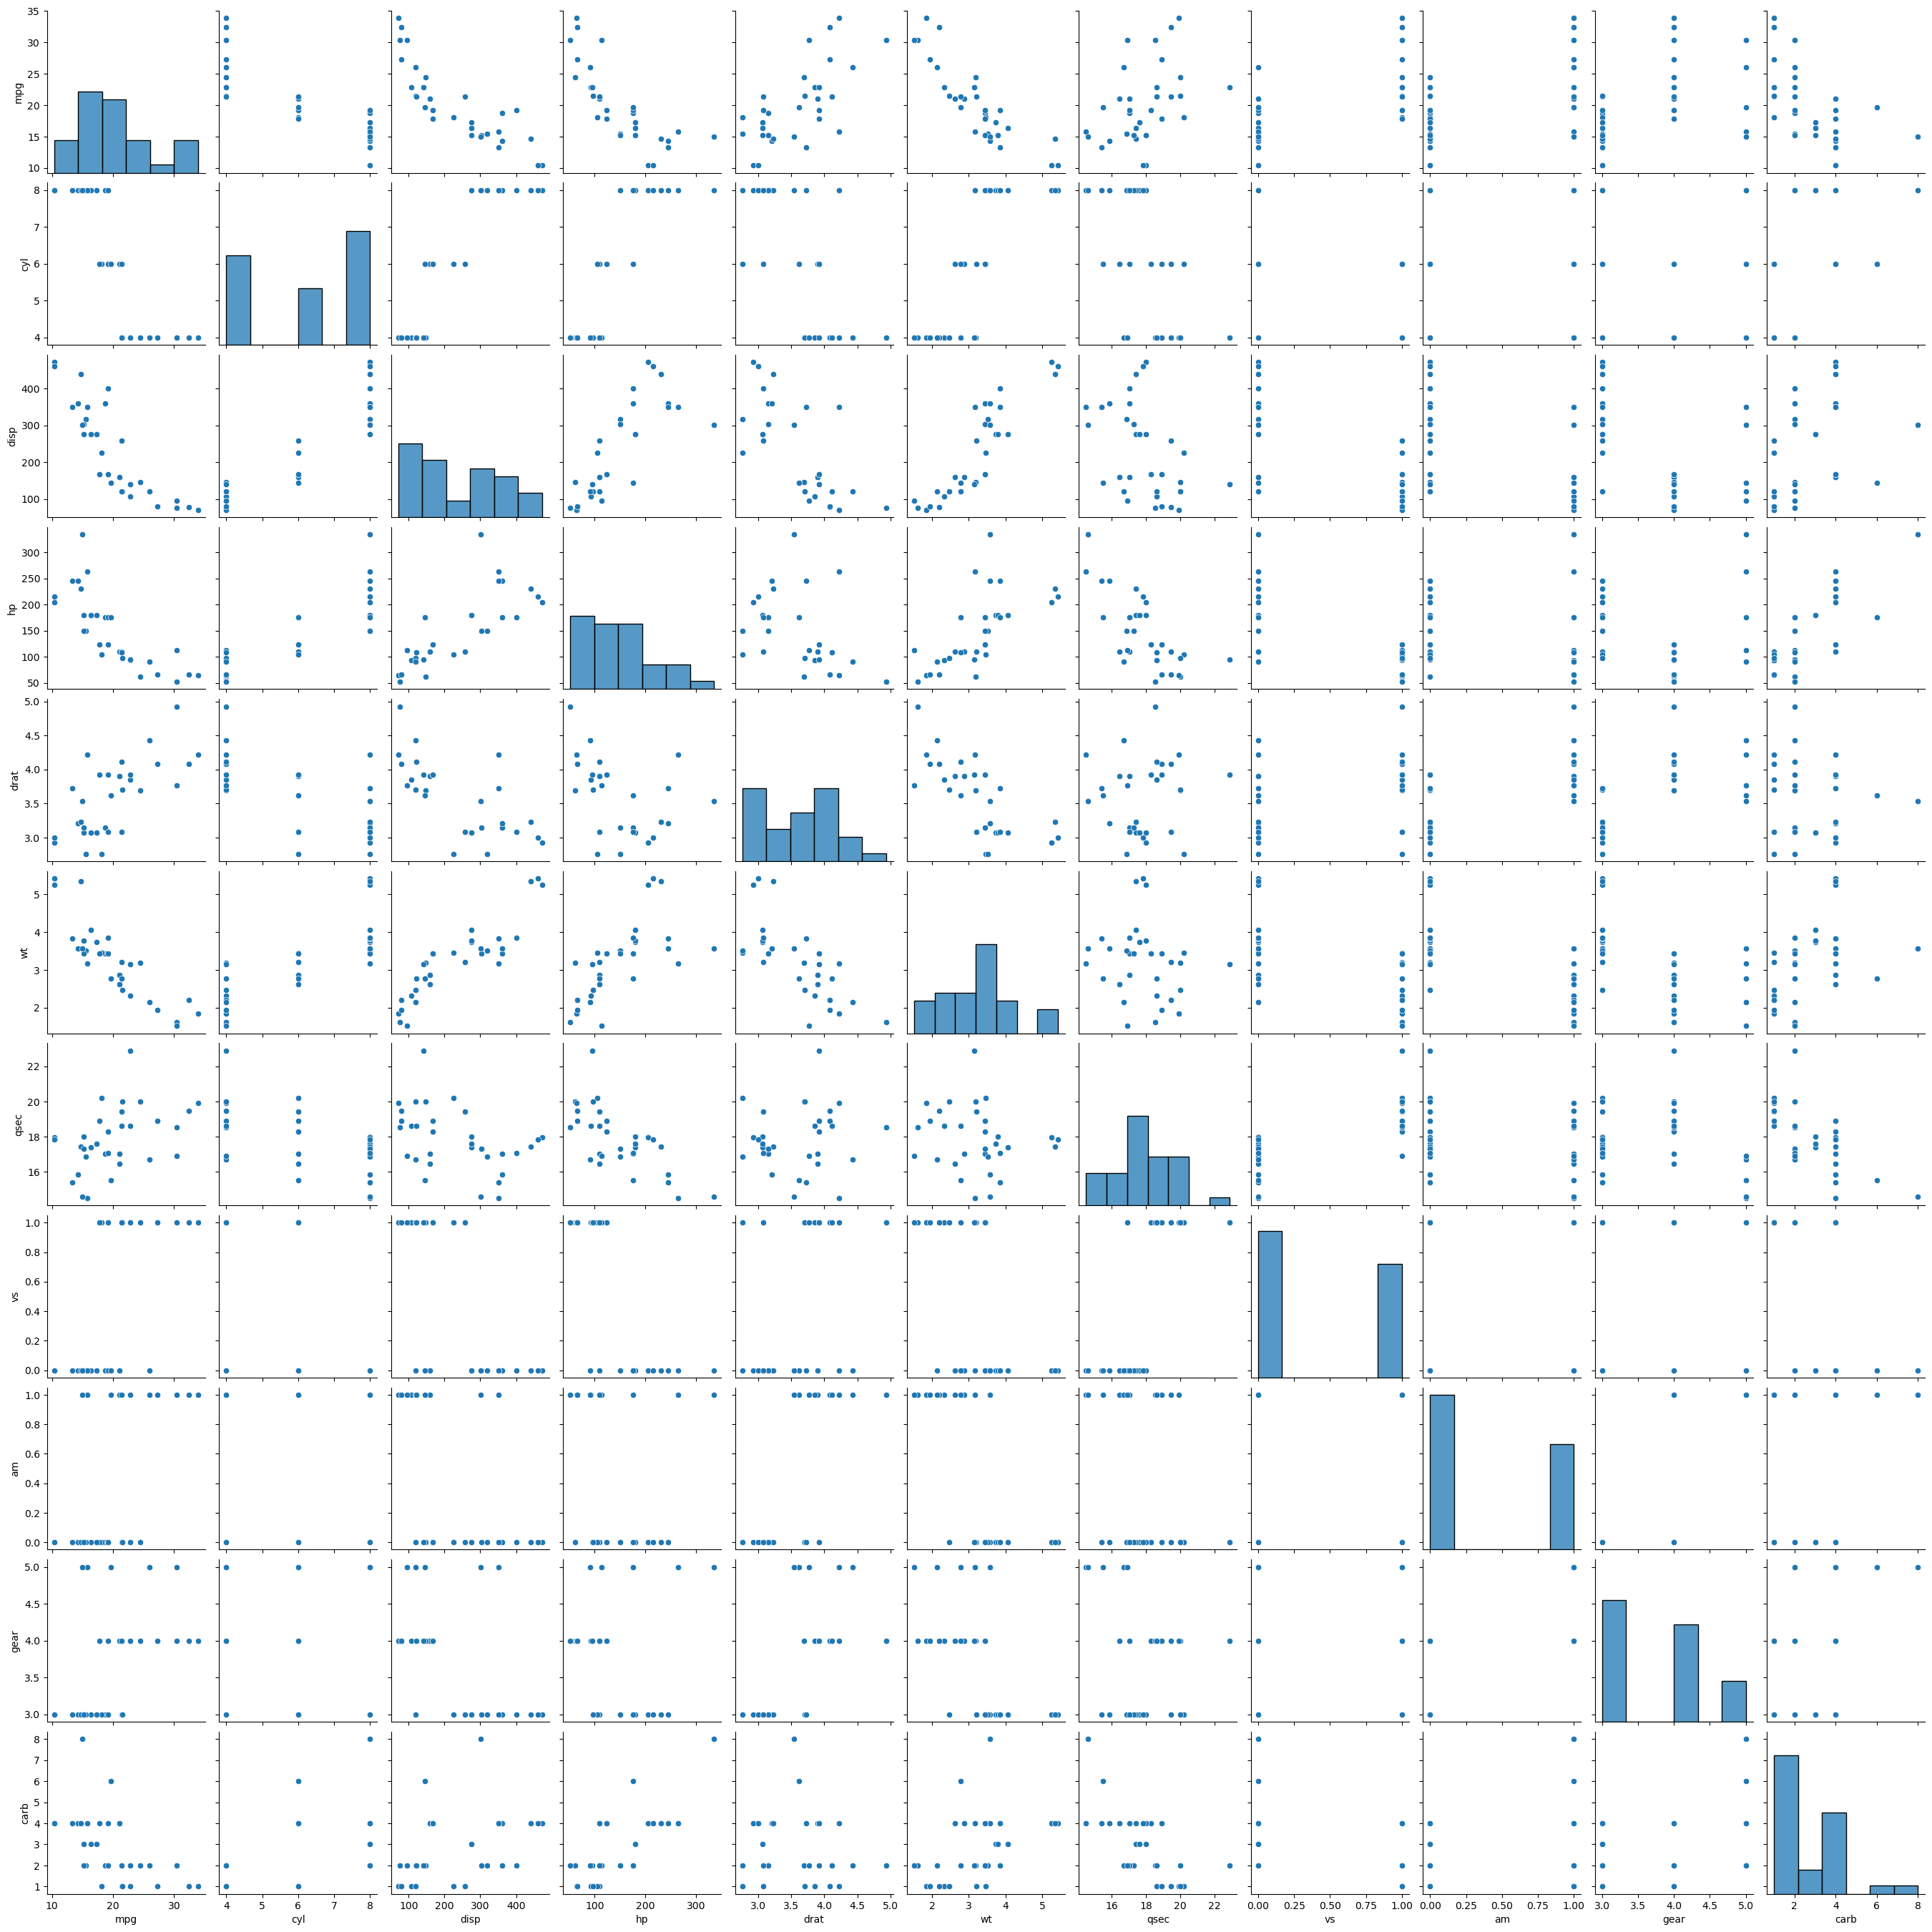

In [7]:
sns.pairplot(df_reg)

## Variance Threshold

One of the most simple screens we can do for the usefullness of a feature is to look at its varaiance. If we have features that are always the same/almost the same value, that's not really very useful in making predictions. By default the variance threshold removes anything with 0 variance, we can provide an argument when creating the function to raise that threshold. 

The variance threshold is especially usefull where we have a large number of features, where some of them are almost always the same value. E.g. in the US some colleges offer a tuition discount for children of employees. If there was a feature like "employee_discount_rate" a few students would have a value, but almost everyone would be 0. This would filter that out. 

This variance based selection is the equivalent of looking at distributions of the features, and filtering out those that don't vary much, or have almost the same value for all observations.

In [8]:
from sklearn.feature_selection import VarianceThreshold
var_th = VarianceThreshold(.2)
print(X.shape)
post_vt = var_th.fit_transform(X)
print(post_vt.shape)

mask = var_th.get_support()
new_features = X.columns[mask]
print(new_features)

(2000, 20)
(2000, 18)
Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width',
       'ram', 'sc_h', 'sc_w', 'talk_time', 'touch_screen', 'wifi'],
      dtype='object')


## Univariate Selection 

Univariate selection looks at one feature at a time, and evaluates it's connection with the target, we can directly utilize some stats skillz to do some feature selection. In stats we saw that if a feature is more correlated with a target, it does a better job of acting as a predictor. This process of feature selection builds on the same concepts. We can use this in combination with some sklearn functions to evaluate that relationship beween targets and features. In sklearn the two features SelectKBest and SelectPercentile can be used to select the best K features or the best percentile of features. 

The best can be evaluated in different ways depending on if we are doing a regression or classification:
<ul>
<li><b>Regression:</b> f_regression (correlation), mutual_info_regression (mutual info).
<li><b>Classification:</b> f_classif (ANOVA), chi2 (~correlation), mutual_info_classif (mutual info)
</ul>

So the feature selection process will select the features that are most "connected" with the target value, where that connection is defined either by some measure of correlation or some measure of mutual information. In plain English, we keep the features that individually tell us the most about the target. 

### Mutual Information

Mutual information feature selection is based on information gain, the same idea that we used to create a tree. Like a tree, this selects variable based on which ones do a better job of increasing the information gain. 

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectPercentile

# K best - broken out
kb = SelectKBest(chi2, k=15)
kb2 = kb.fit(X,y)
post_c2 = kb2.transform(X)
print("K-Best:", post_c2.shape)

#Print the features
mask = kb2.get_support()
new_features = X.columns[mask]
print("K-Best Features:", new_features)


# Percentile - condensed
post_per = SelectPercentile(chi2, percentile=60).fit_transform(X,y)
print("Percentile:", post_per.shape)

#Mutual Info
post_mut_inf = SelectPercentile(score_func=mutual_info_classif, percentile=50).fit_transform(X,y.ravel())
print("Mutual Info:", post_mut_inf.shape)

K-Best: (2000, 15)
K-Best Features: Index(['battery_power', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt',
       'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w',
       'talk_time', 'touch_screen'],
      dtype='object')
Percentile: (2000, 12)
Mutual Info: (2000, 10)


## Internal Selection (Embedded)

Some algorithms give us 'automatic' feature selection as they create their model, as part of the training process. Some examples are:
<ul>
<li>Trees
<li>Lasso Regression
</ul>

We can extract the feature selection results and use that to inform us of which features to keep or remove. 

<Axes: >

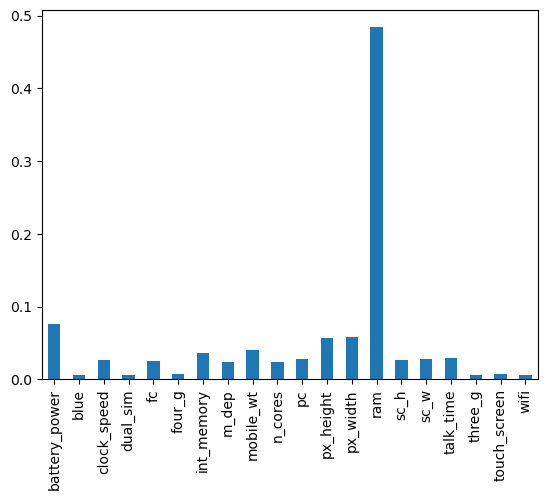

In [10]:
#Forest Example
randFor = RandomForestClassifier()

randFor.fit(X,y)
feat_names = X.columns
for_imp = randFor.feature_importances_
forest_imp = pd.Series(for_imp, index=feat_names)
forest_imp.plot.bar()

In [11]:
#Lasso
lasso = Lasso()
x_reg_dum = pd.get_dummies(Xreg, drop_first=True)
lasso.fit(x_reg_dum, yreg)
coeff = lasso.coef_
print("Zero'd:", np.array(x_reg_dum.columns)[coeff==0])
print("Kept:", np.array(x_reg_dum.columns)[coeff!=0])

Zero'd: ['cyl' 'drat' 'wt' 'qsec' 'vs' 'am' 'gear' 'carb']
Kept: ['disp' 'hp']


### Select from Model

We can use the feature selection aspect of models to do the same selection as above in a more direct way. The SelectFromModel function can be used to select features based on the importance of whatever model we pass in. The L1 Lasso regularization and the tree feature importance can both be used this way since they have the ability to determine the importance of their features. 

<b>Note:</b> The "masK" and get_support bit is a way to get the feature names out of the selection process. The mask is a boolean array that is true for the features that were selected, we then use that to pull out all the selected column names, and print them out. 

#### Lasso Based Selection

In [12]:
#Lasso based 
from sklearn.feature_selection import SelectFromModel
l1_selection = Lasso().fit(x_reg_dum, yreg)
sfm = SelectFromModel(l1_selection, prefit=True)
x_reg_new = sfm.transform(x_reg_dum)
print(x_reg_new.shape)

mask = sfm.get_support()
new_features = x_reg_dum.columns[mask]
print(new_features)

(32, 2)
Index(['disp', 'hp'], dtype='object')


/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


#### Tree Based Selection

In [13]:
#Tree Based
tree_sel = RandomForestClassifier().fit(X, y)
sfm_class = SelectFromModel(tree_sel, prefit=True)
x_new = sfm_class.transform(X)
print(x_new.shape)

mask = sfm_class.get_support()
new_features = X.columns[mask]
print(new_features)

(2000, 4)
Index(['battery_power', 'px_height', 'px_width', 'ram'], dtype='object')


/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


## Recursive Feature Elimination

<b>Note:</b> Recursion is a common programming concept that basically means to continue to repeat the same thing over and over on a smaller version of the same problem. 

Recursive feature elimination uses recursion to keep removing features, creating a smaller and smaller feature set. So we can basically cut a feature at a time out, create a model, and see how well we're doing. The ranking that we print out assigns all the stuff we keep a 1, and a bigger number to other ones. The process of recursive feature elimination looks like this:

![Recursive Feature Elimination](images/rfecv.png "Recursive Feature Elimination")

<b>Note:</b> There is also Sequental Feature Selection, which functions similarly, either removing or adding features one at a time. 

In [14]:
from sklearn.feature_selection import RFE
est = LogisticRegression(max_iter=10000, solver="saga")
rfe = RFE(estimator=est, n_features_to_select=12, step=1)
rfe.fit(X, y)
print(rfe.ranking_)
mask = rfe.get_support()
new_features = X.columns[mask]
print(new_features)

[8 1 1 1 2 1 4 1 5 1 3 7 9 6 1 1 1 1 1 1]
Index(['blue', 'clock_speed', 'dual_sim', 'four_g', 'm_dep', 'n_cores', 'sc_h',
       'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi'],
      dtype='object')


We can also step this up and search for the optimal number of features. RFECV will do a cross-validation and give us a breakdown of our accuracy with different numbers of features included. We can see the optimal number, as well as the relative scores for each number of features. 

Optimal number of features : 20
Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi'],
      dtype='object')


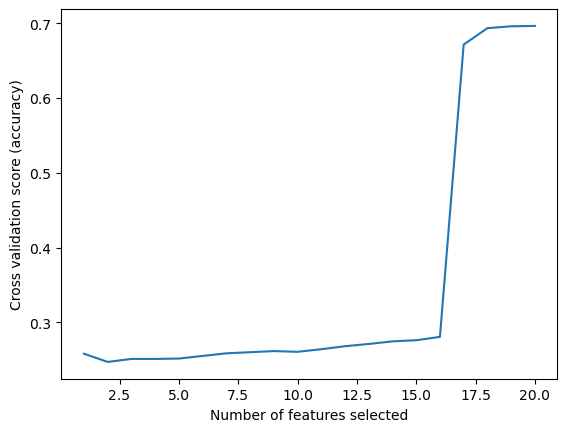

In [15]:
from sklearn.feature_selection import RFECV
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=est,
    step=1,
    cv=3,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)
mask = rfecv.get_support()
new_features = X.columns[mask]
print(new_features)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
)
plt.show()

### Feature Selection in Pipeline

We can stack this feature selection stuff into a pipeline. This will allow us to have the feature selection happen automatically before the model training. Like most other sklearn things, the feature selection functionality fits well into the pipleline processes, so we can arrange it in as one of our step like we would preparation step such as scaling or imputation. 

Here we are using two separate models - a tree based forest for the feature importance bit, and a logistic regression for the actual predictions. We can use use any other models for the prediction bit, even if they don't have a feature importance function.

In [16]:
#Add a pipeline
model = RandomForestClassifier(n_jobs=-1)
pipe_model = LogisticRegression(max_iter=10000, solver="saga")

min_features_to_select = 1  # Minimum number of features to consider
rfecv_pipe = RFECV(
    estimator=pipe_model,
    step=1,
    cv=3,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)

X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y)


pipeline_steps = [("fs", rfecv_pipe),
                ('model', model) ]
pipe = Pipeline(pipeline_steps)
pipe.fit(X_train_, y_train_)
pipe.score(X_test_,y_test_)

0.88

## Feature Selection Usage

Feature selection, in general, will not result in a massive improvement in the accuracy of our model unless the data that we are selecting out is truly "bad". So it is pretty likely that other techniques such as hyperparameter selection will be better at improving accuracy.

As well, some techniques that we looked at, and some we will soon, perform the same/similar work as feature selection. For example, regularization will remove/minimize features that are not important. Other techniques, such as PCA, will create new features that are a combination of the old ones. That said, feature selection is still a useful tool to have in your toolbox, and can be used in combination with other techniques. Most notably, we can remove features that are not significant in helping us make predictions or are not relevant to what we want to predict. Making models with smaller feature sets is, in and of itself, an improvement. We can also more closely tie features to outcomes if we have a smaller set of features, and there are times where this may be important, such as if we are trying to explain the model to a non-technical audience. 

On the whole, feature selection is something we need to know, but it is something that is only sometimes important in real applications. It isn't odd to do feature selection, but it also isn't odd to not do it. In the emerging development of larger and smarter predictive models, feature selection is less important and deep learning models can use millions or billions of features without issue. One thing we do need to note is that there is a balance between the number of features and the number of observations - if we have a lot of features and a small number of observations, we can run into issues with overfitting. These large deep learning models are trained with massive amounts of data, so the huge feature sets are manageable.

In most cases, we have a relatively small number of features that provide a lot of information, and then further ones are less significant but still useful:

![Feature Selection](images/feat_imp.png "Feature Selection")

## Exercise - Feature Selection on Pixels

We can try to do some feature selection on the pixels of our number images. The pixels around the edges are pretty much white for every digit, so I suspect that those are somewhat less important than the middle pixels. Remember, each pixel is a feature. 

In [17]:
#Load mnist data
#Load Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
Xp, yp = mnist["data"], mnist["target"]
print(Xp.shape)
print(yp.shape)

/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)


In [18]:
#Feature selection 1 - e.g. variance thresh

In [19]:
#Feature selection 2 - e.g. rfecv
#May need to use a subset to keep size manageable. 

In [20]:
#Plot Results

## Feature Selection on Pixels - Sample Solution

We can try to do some feature selection on the pixels of our number images. The pixels around the edges are pretty much white for every digit, so I suspect that those are somewhat less important than the middle pixels. Remember, each pixel is a feature. 

In [21]:
#Load Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
Xp, yp = mnist["data"], mnist["target"]
print(Xp.shape)
print(yp.shape)

/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)


Do a simple filter - check the variance. 

In [22]:
var_pix = VarianceThreshold(.3)
print(Xp.shape)
post_pix = var_pix.fit_transform(Xp)
print(post_pix.shape)

(70000, 784)
(70000, 685)


Use Recursive Feature Selection. 

<b>Note:</b> this will likely take a while to run. Using a smaller subset of the data will speed things up, feel free to cut down on the size of the data for efficiency. 

In [23]:
samp_size = 1000
min_features = 100
est_img = RandomForestClassifier(n_estimators=30, ccp_alpha=.01, n_jobs=-1)

rfecvp = RFECV(
    estimator=est_img,
    step=1,
    cv=3,
    scoring="f1_weighted",
    min_features_to_select=min_features,
)
rfecvp.fit(Xp[:samp_size], yp[:samp_size])

RFECV(cv=3,
      estimator=RandomForestClassifier(ccp_alpha=0.01, n_estimators=30,
                                       n_jobs=-1),
      min_features_to_select=100, scoring='f1_weighted')

Optimal number of features : 665


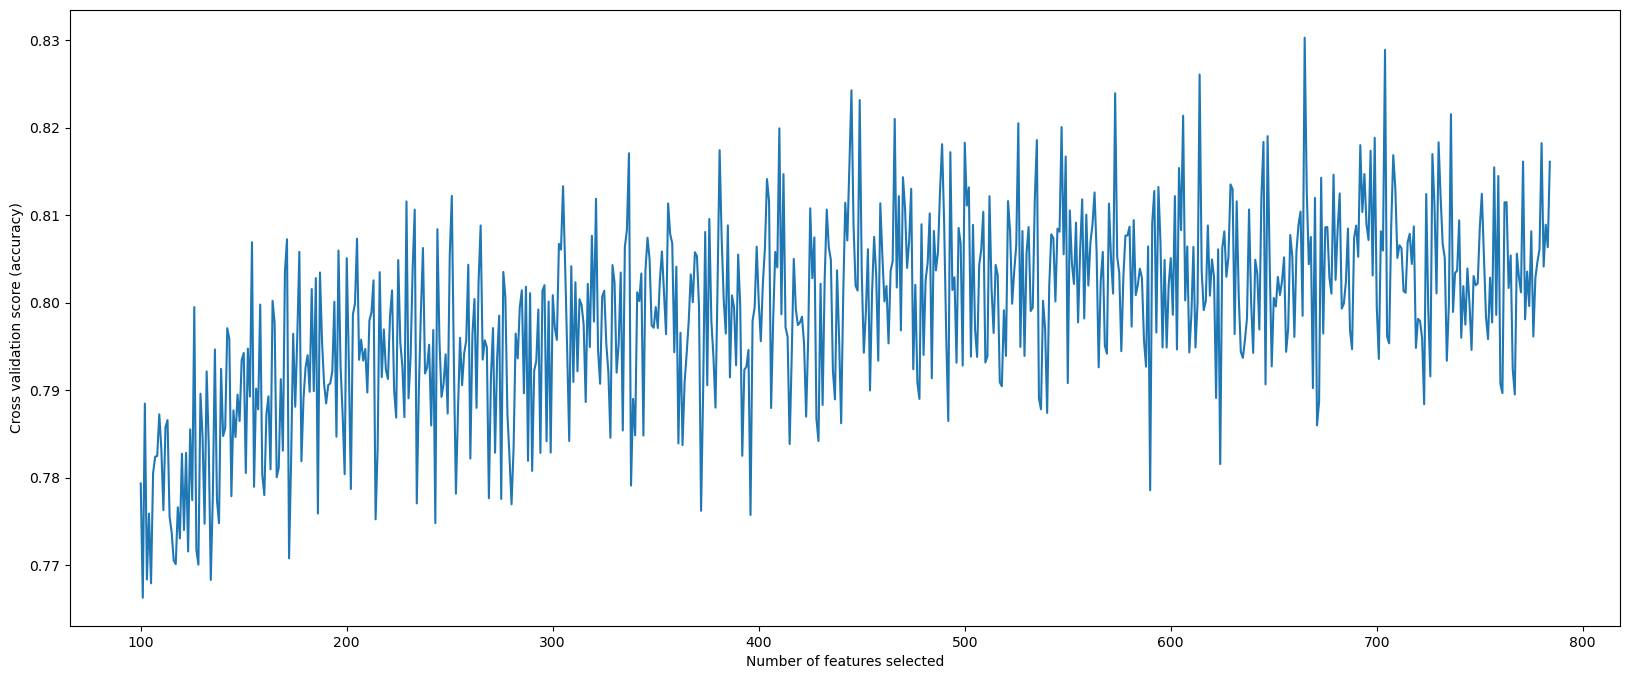

In [24]:
print("Optimal number of features : %d" % rfecvp.n_features_)
plt.rcParams["figure.figsize"] = (20,8)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features, len(rfecvp.cv_results_["mean_test_score"]) + min_features),
    rfecvp.cv_results_["mean_test_score"],
)
plt.show()

### Results

The exact details will vary a bit, but we can see our accuracy flattening out at some point. We could likely filter out ~250 pixels or so from the data and get similar levels of accuracy while using less of the data as inputs to the model. These removed features are likely the outer edges of each image, that are pretty much always white; those don't add any predictive value because they don't vary from image to image. 

Making models on all 70000 images took a while last time with linear regression, so making a change like this will probably save some noticable processing time. On bigger datasets, with more pixels, and more color, these types of changes can start to add up. When dealing with data that is even larger, this compounds - our images are 784 pixels of greyscale, an iPhone 14 has a camera that takes color images that are 48 million pixels. 

![Feature Selection](images/feat_sel_pix.png "Feature Selection" )
